# GNN Link Prediction — Model Evaluation

Evaluation of the knowledge-graph GNN for **(Pralsetinib, inhibits, Protein)** link prediction with a **train/test split** on known off-target edges. Metrics and figures are suitable for reporting (e.g. poster).

In [1]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Project root: assume notebook is in notebooks/; if cwd is project root, use it
_cwd = Path(".").resolve()
if (_cwd / "data" / "kg_nodes_final.csv").exists():
    PROJECT_ROOT = _cwd
else:
    PROJECT_ROOT = _cwd.parent
SCRIPT_DIR = PROJECT_ROOT / "scripts" / "modeling" / "gnn"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPT_DIR))

from kg_gnn_data import (
    get_positive_and_candidate_tails,
    get_protein_outcome_pairs,
    load_kg_graph,
    negative_sampling,
)
from kg_gnn_model import GCNLinkPredictor

# Poster-friendly style
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11
sns.set_theme(style="whitegrid", palette="husl")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

c:\Users\suchi\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data and train/test split

Load the KG and split known **(Pralsetinib, inhibits, Protein)** edges into train (80%) and test (20%) for evaluation.

In [2]:
DATA_DIR = PROJECT_ROOT / "data"
nodes_path = DATA_DIR / "kg_nodes_final.csv"
edges_path = DATA_DIR / "kg_edges_final.csv"
assert nodes_path.exists() and edges_path.exists(), "Run from repo with data/kg_nodes_final.csv and data/kg_edges_final.csv"

data, id_to_idx = load_kg_graph(nodes_path, edges_path)
idx_to_id = {v: k for k, v in id_to_idx.items()}

positive_tails, candidate_tails, drug_idx = get_positive_and_candidate_tails(
    edges_path, id_to_idx, nodes_path
)
n_pos = len(positive_tails)
assert n_pos > 0, "No positive (Pralsetinib, inhibits, protein) edges found."

# Train/test split: hold out 20% + 1 extra protein edge
test_frac = 0.2
n_test = max(1, int(round(test_frac * n_pos))) + 1
indices = list(range(n_pos))
random.shuffle(indices)
train_pos = [positive_tails[i] for i in indices[n_test:]]
test_pos = [positive_tails[i] for i in indices[:n_test]]

print(f"Known positives: {n_pos}")
print(f"Train: {len(train_pos)}  |  Test (held-out): {len(test_pos)}")
print(f"Candidate proteins (ranking pool): {len(candidate_tails)}")

Known positives: 13
Train: 9  |  Test (held-out): 4
Candidate proteins (ranking pool): 516


## 2. Train GNN on training set only

Negative sampling uses only non-positive candidates. Outcome (protein–outcome) auxiliary task is optional.

In [3]:
# Negatives for training (exclude all known positives so test set is never used in loss)
neg_pairs = negative_sampling(
    drug_idx, train_pos, candidate_tails,
    num_negatives_per_positive=5, seed=SEED,
)
neg_tail_indices = [p[1] for p in neg_pairs]

# Optional outcome task (same as main script)
outcome_pos_pairs, candidate_outcomes, protein_to_outcomes = get_protein_outcome_pairs(
    edges_path, id_to_idx, nodes_path
)
outcome_neg_src, outcome_neg_dst = [], []
outcome_pos_pairs_matched = []
if outcome_pos_pairs and candidate_outcomes:
    outcome_set = set(candidate_outcomes)
    for (p, o) in outcome_pos_pairs:
        pos_out = protein_to_outcomes.get(p, set())
        neg_candidates = [x for x in outcome_set if x not in pos_out]
        if neg_candidates:
            outcome_pos_pairs_matched.append((p, o))
            outcome_neg_src.append(p)
            outcome_neg_dst.append(random.choice(neg_candidates))
    if len(outcome_pos_pairs_matched) > 2000:
        idx = random.sample(range(len(outcome_pos_pairs_matched)), 2000)
        outcome_pos_pairs_matched = [outcome_pos_pairs_matched[i] for i in idx]
        outcome_neg_src = [outcome_neg_src[i] for i in idx]
        outcome_neg_dst = [outcome_neg_dst[i] for i in idx]
    use_outcome_task = len(outcome_pos_pairs_matched) > 0
else:
    use_outcome_task = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_gpu = data.to(device)
in_channels = data_gpu.x.size(1)
model = GCNLinkPredictor(
    in_channels=in_channels, hidden_channels=64, out_channels=32,
    num_layers=2, dropout=0.3,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

pos_tensor = torch.tensor(train_pos, dtype=torch.long, device=device)
neg_tensor = torch.tensor(neg_tail_indices, dtype=torch.long, device=device)
if use_outcome_task:
    pos_src_t = torch.tensor([p for p, _ in outcome_pos_pairs_matched], dtype=torch.long, device=device)
    pos_dst_t = torch.tensor([o for _, o in outcome_pos_pairs_matched], dtype=torch.long, device=device)
    neg_src_t = torch.tensor(outcome_neg_src, dtype=torch.long, device=device)
    neg_dst_t = torch.tensor(outcome_neg_dst, dtype=torch.long, device=device)

epochs = 200
train_losses = []
outcome_losses = []
total_losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    h = model(data_gpu)

    loss_main = model.loss_batch(h, drug_idx, pos_tensor, neg_tensor)
    loss = loss_main
    loss_out = None
    if use_outcome_task:
        loss_out = model.loss_outcome_batch(h, pos_src_t, pos_dst_t, neg_src_t, neg_dst_t)
        loss = loss + 0.5 * loss_out

    loss.backward()
    optimizer.step()

    train_losses.append(loss_main.item())
    if use_outcome_task and loss_out is not None:
        outcome_losses.append(loss_out.item())
        total_losses.append(loss.item())
    else:
        total_losses.append(loss_main.item())

    if (epoch + 1) % 50 == 0 or epoch == 0 or epoch == epochs - 1:
        if use_outcome_task and loss_out is not None:
            print(
                f"Epoch {epoch+1}/{epochs}, main = {loss_main.item():.4f}, "
                f"outcome = {loss_out.item():.4f}, total = {loss.item():.4f}"
            )
        else:
            print(f"Epoch {epoch+1}/{epochs}, loss = {loss_main.item():.4f}")

print("Training done.")

Epoch 1/200, main = 0.7083, outcome = 0.6988, total = 1.0577
Epoch 50/200, main = 0.0674, outcome = 0.3278, total = 0.2313
Epoch 100/200, main = 0.0152, outcome = 0.3206, total = 0.1755
Epoch 150/200, main = 0.0126, outcome = 0.3240, total = 0.1746
Epoch 200/200, main = 0.0041, outcome = 0.2860, total = 0.1471
Training done.


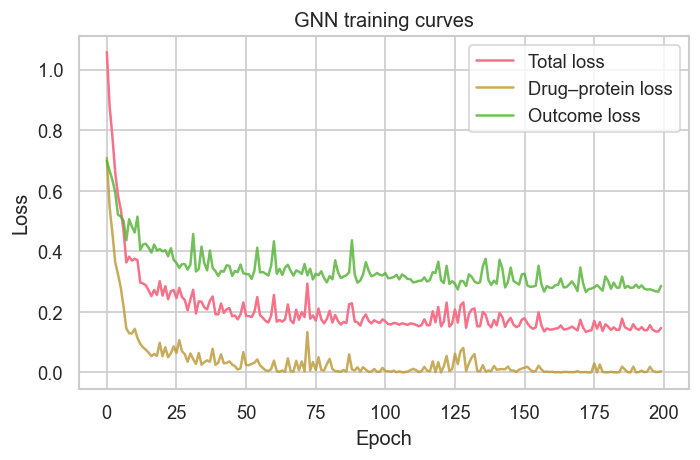

In [4]:
# GNN training curves
plt.figure(figsize=(6, 4))
plt.plot(total_losses, label="Total loss")
plt.plot(train_losses, label="Drug–protein loss", alpha=0.8)
if use_outcome_task and len(outcome_losses) == epochs:
    plt.plot(outcome_losses, label="Outcome loss", alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN training curves")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Evaluate on held-out test set

Score all candidate proteins and compute where held-out positives rank. Then compute **Recall@k**, **MRR**, and rank statistics.

In [5]:
model.eval()
with torch.no_grad():
    h = model(data_gpu)
    cand_tensor = torch.tensor(candidate_tails, dtype=torch.long, device=device)
    scores = model.predict_link(h, drug_idx, cand_tensor)
    scores_np = scores.cpu().numpy()

# Rank order (descending score)
order = scores_np.argsort()[::-1]  # indices into candidate_tails
test_set = set(test_pos)

# For each test positive, get its 1-based rank (or None if not in candidates)
pos_to_rank = {}
for rank_1based, idx in enumerate(order, start=1):
    tail_idx = candidate_tails[idx]
    if tail_idx in test_set and tail_idx not in pos_to_rank:
        pos_to_rank[tail_idx] = rank_1based
    if len(pos_to_rank) == len(test_set):
        break

# Ranks of test positives (use n_candidates+1 for unranked)
n_candidates = len(candidate_tails)
ranks = [pos_to_rank.get(p, n_candidates + 1) for p in test_pos]

# Metrics (Recall@k only up to k=20)
k_list = [5, 10, 20]
recall_at_k = {}
for k in k_list:
    recall_at_k[k] = sum(1 for r in ranks if r <= k) / len(test_pos) if test_pos else 0.0

# MRR: mean of 1/rank
mrr = np.mean([1.0 / r for r in ranks]) if ranks else 0.0
mean_rank = np.mean(ranks)
median_rank = np.median(ranks)

# Store for tables/plots
metrics_summary = {
    "Recall@5": recall_at_k[5],
    "Recall@10": recall_at_k[10],
    "Recall@20": recall_at_k[20],
    "MRR": mrr,
    "Mean rank": mean_rank,
    "Median rank": median_rank,
}
print("Test set metrics:")
for name, val in metrics_summary.items():
    if "Recall" in name or "MRR" in name:
        print(f"  {name}: {val:.3f}")
    else:
        print(f"  {name}: {val:.1f}")

Test set metrics:
  Recall@5: 0.250
  Recall@10: 0.500
  Recall@20: 1.000
  MRR: 0.147
  Mean rank: 11.5
  Median rank: 11.5


## 4. Poster-ready summary table

Styled metrics table suitable for a report or poster.

In [6]:
# Summary table for poster/report
df_metrics = pd.DataFrame([
    {"Metric": "Train size", "Value": f"{len(train_pos)}"},
    {"Metric": "Test size (held-out)", "Value": f"{len(test_pos)}"},
    {"Metric": "Recall@5", "Value": f"{metrics_summary['Recall@5']:.2%}"},
    {"Metric": "Recall@10", "Value": f"{metrics_summary['Recall@10']:.2%}"},
    {"Metric": "Recall@20", "Value": f"{metrics_summary['Recall@20']:.2%}"},
    {"Metric": "MRR", "Value": f"{metrics_summary['MRR']:.3f}"},
    {"Metric": "Mean rank (test)", "Value": f"{metrics_summary['Mean rank']:.1f}"},
    {"Metric": "Median rank (test)", "Value": f"{metrics_summary['Median rank']:.1f}"},
])
df_metrics.style.set_properties(**{"text-align": "left"}).set_table_styles([
    {"selector": "th", "props": [("font-weight", "bold"), ("background-color", "#f0f0f0")]},
])

,Metric,Value
0,Train size,9
1,Test size (held-out),4
2,Recall@5,25.00%
3,Recall@10,50.00%
4,Recall@20,100.00%
5,MRR,0.147
6,Mean rank (test),11.5
7,Median rank (test),11.5


## 5. Visualizations for poster

**Left:** Recall@k bar chart. **Right:** Rank distribution of held-out test positives.

Embedding tensor shape: torch.Size([1081, 32])
Embedding norms: mean = 10.982, std = 10.802


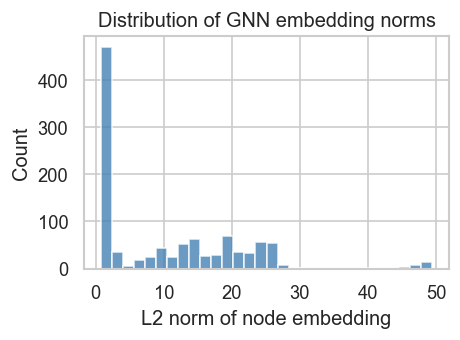

In [7]:
# 3a. Inspect GNN node embeddings
model.eval()
with torch.no_grad():
    h = model(data_gpu)  # [num_nodes, embed_dim]

print("Embedding tensor shape:", h.shape)

h_cpu = h.cpu().numpy()
emb_norms = np.linalg.norm(h_cpu, axis=1)

print("Embedding norms: mean = {:.3f}, std = {:.3f}".format(
    emb_norms.mean(), emb_norms.std()
))

plt.figure(figsize=(4, 3))
plt.hist(emb_norms, bins=30, color="steelblue", alpha=0.8)
plt.xlabel("L2 norm of node embedding")
plt.ylabel("Count")
plt.title("Distribution of GNN embedding norms")
plt.tight_layout()
plt.show()

Positive scores: mean = 0.842, std = 0.350
Negative scores: mean = 0.000, std = 0.000


C:\Users\suchi\AppData\Local\Temp\ipykernel_21668\1540859992.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


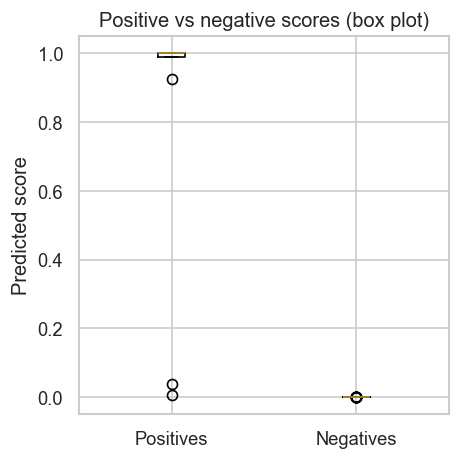

In [8]:
# 3b. Positive vs negative score distributions for (Pralsetinib, protein)
model.eval()
with torch.no_grad():
    # All known positives (train + test)
    all_pos_tails = torch.tensor(positive_tails, dtype=torch.long, device=device)
    pos_scores = model.predict_link(h, drug_idx, all_pos_tails).cpu().numpy()

    # Sample negatives from candidate_tails that are not positives
    pos_set = set(positive_tails)
    neg_pool = [t for t in candidate_tails if t not in pos_set]
    neg_sample = random.sample(neg_pool, min(len(neg_pool), len(positive_tails) * 5))
    neg_tails_t = torch.tensor(neg_sample, dtype=torch.long, device=device)
    neg_scores = model.predict_link(h, drug_idx, neg_tails_t).cpu().numpy()

print("Positive scores: mean = {:.3f}, std = {:.3f}".format(pos_scores.mean(), pos_scores.std()))
print("Negative scores: mean = {:.3f}, std = {:.3f}".format(neg_scores.mean(), neg_scores.std()))

plt.figure(figsize=(4, 4))
plt.boxplot(
    [pos_scores, neg_scores],
    labels=["Positives", "Negatives"],
    showfliers=True,
)
plt.ylabel("Predicted score")
plt.title("Positive vs negative scores (box plot)")
plt.tight_layout()
plt.show()

In [9]:
# 3c. Top-k ranked proteins with readable labels
nodes_df = pd.read_csv(nodes_path)
id_col = None
for cand in ["node_id", "id", "index", "nodeIndex", "node_index"]:
    if cand in nodes_df.columns:
        id_col = cand
        break
if id_col is None:
    print(
        "Warning: could not find an ID column in nodes_df; using raw idx values as labels. "
        f"Available columns: {list(nodes_df.columns)!r}"
    )

def idx_to_label(idx):
    node_id = idx_to_id[idx]
    if id_col is None:
        return str(node_id)
    row = nodes_df.loc[nodes_df[id_col] == node_id]
    if not row.empty:
        # Try common name/label columns; fall back to node_id
        for col in ["name", "label", "preferred_name"]:
            if col in row.columns:
                val = row.iloc[0].get(col)
                if isinstance(val, str) and val.strip():
                    return val
        return str(node_id)
    return str(node_id)

k_top = 20
rows = []
for rank_1based, idx in enumerate(order[:k_top], start=1):
    tail_idx = candidate_tails[idx]
    label = idx_to_label(tail_idx)
    is_train = tail_idx in train_pos
    is_test = tail_idx in test_pos
    score = float(scores_np[idx])
    status = "train_pos" if is_train else ("test_pos" if is_test else "candidate")
    rows.append({
        "rank": rank_1based,
        "protein_idx": tail_idx,
        "protein_label": label,
        "score": score,
        "status": status,
    })

top_proteins_df = pd.DataFrame(rows)
top_proteins_df

,rank,protein_idx,protein_label,score,status
0,1,1,RET - ret proto-oncogene (human),0.999686,train_pos
1,2,2,CCDC6 - coiled-coil domain containing 6 (human),0.999659,train_pos
2,3,3,Proto-oncogene tyrosine-protein kinase recepto...,0.999629,test_pos
3,4,4,Tyrosine-protein kinase JAK2 (human),0.999596,train_pos
4,5,5,KIF5B - kinesin family member 5B (human),0.999560,train_pos
5,6,6,FLT3 - fms related receptor tyrosine kinase 3 ...,0.999520,train_pos
6,7,7,KDR - kinase insert domain receptor (human),0.999476,test_pos
7,8,12,KDR,0.996831,train_pos
8,9,13,DRD2,0.995461,train_pos
9,10,15,CCDC6,0.988610,train_pos


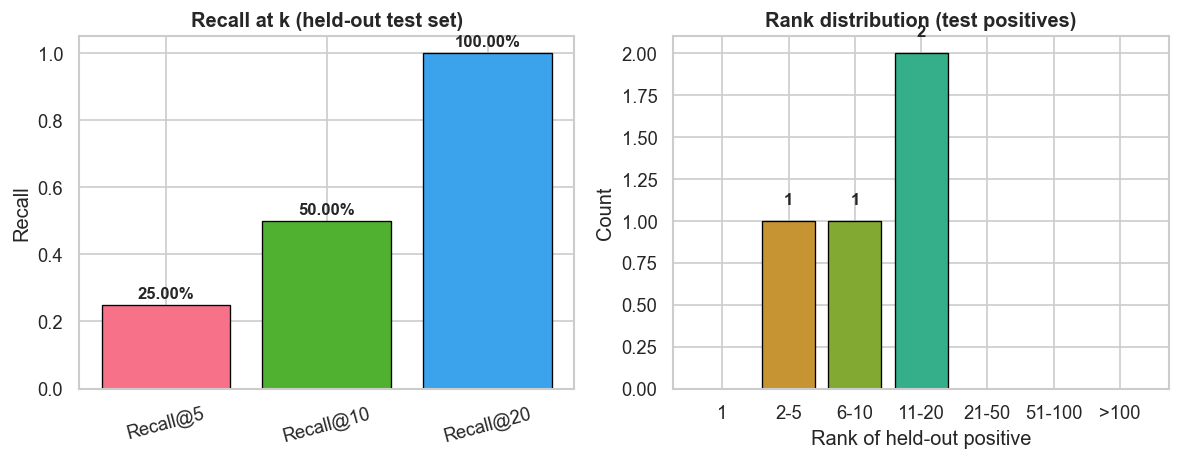

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Recall@k bar chart
ax1 = axes[0]
x = [f"Recall@{k}" for k in k_list]
y = [recall_at_k[k] for k in k_list]
bars = ax1.bar(x, y, color=sns.color_palette("husl", len(k_list)), edgecolor="black", linewidth=0.8)
ax1.set_ylabel("Recall", fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.set_title("Recall at k (held-out test set)", fontsize=12, fontweight="bold")
for b, v in zip(bars, y):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")
ax1.tick_params(axis="x", rotation=15)

# Rank distribution (test positives)
ax2 = axes[1]
def bucket_rank(r):
    if r <= 1: return 0
    if r <= 5: return 1
    if r <= 10: return 2
    if r <= 20: return 3
    if r <= 50: return 4
    if r <= 100: return 5
    return 6
rank_labels = ["1", "2-5", "6-10", "11-20", "21-50", "51-100", ">100"]
counts = [sum(1 for r in ranks if bucket_rank(r) == i) for i in range(7)]
colors = sns.color_palette("husl", len(rank_labels))
bars2 = ax2.bar(rank_labels, counts, color=colors, edgecolor="black", linewidth=0.8)
ax2.set_xlabel("Rank of held-out positive", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Rank distribution (test positives)", fontsize=12, fontweight="bold")
for b, c in zip(bars2, counts):
    if c > 0:
        ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1, str(c), ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

## 6. Recall@k curve (line plot)

Classic link-prediction plot: recall as a function of k. Good for comparing models or for a methods figure.

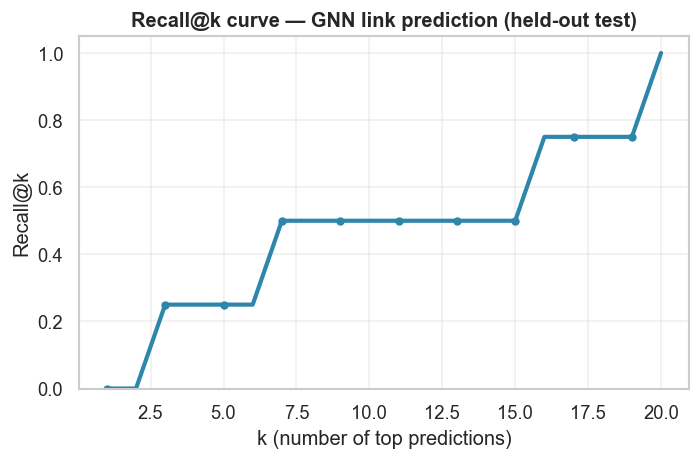

In [11]:
# Recall@k for k = 1 .. 20
k_range = list(range(1, min(21, n_candidates + 1)))
recall_curve = [sum(1 for r in ranks if r <= k) / len(test_pos) for k in k_range] if test_pos else [0.0] * len(k_range)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_range, recall_curve, color="#2e86ab", linewidth=2.5, marker="o", markersize=4, markevery=2)
ax.set_xlabel("k (number of top predictions)", fontsize=12)
ax.set_ylabel("Recall@k", fontsize=12)
ax.set_title("Recall@k curve — GNN link prediction (held-out test)", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. GNN vs baseline comparison

Load the **canonical** pipeline outputs for model eval: **`predictions/off_target_predictions.csv`** (GNN rankings plus KG-derived effects and path-based reasoning) and **`predictions/off_target_predictions_baseline.csv`**. We compare **known targets in top-k** for each model, **overlap** in top-k proteins, and a side-by-side bar chart. The baseline uses only direct (Pralsetinib, inhibits, protein) edge weights; the GNN file uses the full graph and learned embeddings (same ranking as the raw GNN output).

**Fairness caveat:** This comparison is **not fully fair**. The pipeline GNN is trained on **all** known (drug, inhibits, protein) edges, so the "known targets" in the CSV are exactly the targets the GNN was trained to score highly. Counting how many appear in top-k partly measures **training-set reconstruction**, not generalization. The baseline never sees those edges as training labels—it only ranks by edge strength—so it does not get that advantage. For a **fair** evaluation, use the **held-out test set** in sections 1–6: the GNN is trained only on the training positives and evaluated on held-out proteins; that Recall@k is a proper out-of-sample comparison. To compare GNN vs baseline on the same footing, you could run `eval_gnn_holdout.py` (which holds out a fraction of known edges for testing) and evaluate the baseline on that same holdout set.

,k,GNN known in top-k,Baseline known in top-k,Overlap (proteins)
0,5,4,5,2
1,10,9,7,3
2,20,13,7,7


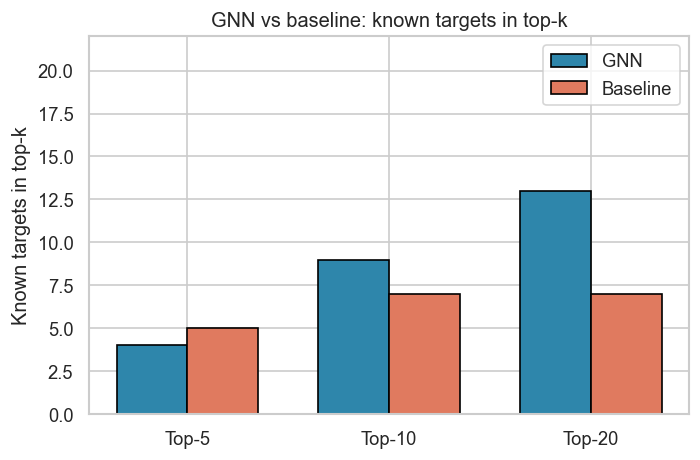

In [12]:
# Load canonical pipeline outputs (run train → build_off_target_predictions.py and baseline script)
pred_dir = PROJECT_ROOT / "predictions"
gnn_path = pred_dir / "off_target_predictions.csv"   # canonical: GNN + KG effects + reasoning
base_path = pred_dir / "off_target_predictions_baseline.csv"

if not gnn_path.exists() or not base_path.exists():
    print("Run the pipeline (train GNN, build_off_target_predictions.py, baseline) to generate prediction CSVs.")
else:
    df_gnn = pd.read_csv(gnn_path)
    df_base = pd.read_csv(base_path)
    df_gnn["protein_id"] = df_gnn["protein_id"].astype(str)
    df_base["protein_id"] = df_base["protein_id"].astype(str)

    total_known_gnn = int(df_gnn["known_target"].sum())
    total_known_base = int(df_base["known_target"].sum())
    k_list_comp = [5, 10, 20]
    rows_comp = []
    for k in k_list_comp:
        top_gnn = set(df_gnn.nsmallest(k, "rank")["protein_id"])
        top_base = set(df_base.nsmallest(k, "rank")["protein_id"])
        known_gnn = int(df_gnn.nsmallest(k, "rank")["known_target"].sum())
        known_base = int(df_base.nsmallest(k, "rank")["known_target"].sum())
        overlap = len(top_gnn & top_base)
        rows_comp.append({
            "k": k,
            "GNN known in top-k": known_gnn,
            "Baseline known in top-k": known_base,
            "Overlap (proteins)": overlap,
        })

    df_comp = pd.DataFrame(rows_comp)
    display(df_comp.style.set_properties(**{"text-align": "left"}).set_table_styles([
        {"selector": "th", "props": [("font-weight", "bold"), ("background-color", "#f0f0f0")]},
    ]))

    # Bar chart: GNN vs baseline — known targets in top-k
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(k_list_comp))
    width = 0.35
    ax.bar(x - width/2, [r["GNN known in top-k"] for r in rows_comp], width, label="GNN", color="#2e86ab", edgecolor="black")
    ax.bar(x + width/2, [r["Baseline known in top-k"] for r in rows_comp], width, label="Baseline", color="#e07a5f", edgecolor="black")
    ax.set_xticks(x)
    ax.set_xticklabels([f"Top-{k}" for k in k_list_comp])
    ax.set_ylabel("Known targets in top-k")
    ax.set_title("GNN vs baseline: known targets in top-k")
    ax.legend()
    ax.set_ylim(0, max(k_list_comp) * 1.1)
    plt.tight_layout()
    plt.show()